In [1]:
import sklearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(font_scale=1.5, rc={'figure.figsize': [12, 8]})
sklearn.set_config(display='diagram')

## Load Acadia Data

In [3]:
data_import = pd.read_csv('/Users/sitanshurupani/Data Science Coursework/Sem 4/GQP - National Parks/DataSpell Project/Data/Daily_attendance.csv')
all_years_test = data_import
all_years_test.set_index('Full_Date', inplace=True)

all_years_test.index = pd.to_datetime(all_years_test.index)
ds = all_years_test.index.to_series()

all_years_test['YEAR'] = ds.dt.year
all_years_test['MONTH'] = ds.dt.month
all_years_test['DAY_OF_WEEK'] = ds.dt.dayofweek
all_years_test['DAY'] = ds.dt.day
all_years_test['value'] = all_years_test['value'].astype(int)

all_years_test.drop(columns=['snow_1h', 'temp_max', 'temp_min','YEAR', 'wind_gust', 'pressure'], inplace=True)
all_years_test["federal_holiday_flag"] = all_years_test["federal_holiday_flag"].astype(int)
all_years_test["school_holiday_flag"] = all_years_test["school_holiday_flag"].astype(int)

In [4]:
X = all_years_test[['temp', 'humidity', 'wind_speed', 'rain_1h', 'federal_holiday_flag', 'school_holiday_flag', 'MONTH', 'DAY_OF_WEEK', 'DAY']]
y = all_years_test['value']

### Split data

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Column Transformer

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer

numerical_features = ['temp', 'humidity', 'wind_speed', 'rain_1h']
cat_features = ['federal_holiday_flag', 'school_holiday_flag', 'MONTH', 'DAY_OF_WEEK','DAY']

ct = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_features),
    ('categorical', OneHotEncoder(sparse=False, handle_unknown='error', drop='if_binary'), cat_features)
])

### Pipeline

In [7]:
from sklearn.linear_model import PoissonRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pois_reg = Pipeline([
    ('prep', ct),
    # ('reg', PoissonRegressor(alpha=1.0, max_iter=300))
    ('reg', PoissonRegressor(alpha=1.0, max_iter=100, fit_intercept=True, tol=1e-09))
])

pois_reg

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['temp', 'humidity',
                                                   'wind_speed', 'rain_1h']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False),
                                                  ['federal_holiday_flag',
                                                   'school_holiday_flag',
                                                   'MONTH', 'DAY_OF_WEEK',
                                                   'DAY'])])),
                ('reg', PoissonRegressor(tol=1e-09))])

In [8]:
pois_reg.fit(X_train, y_train);

In [9]:
pois_reg.score(X_test, y_test)

0.09440109801035179

### What about ridge?

In [10]:
from sklearn.linear_model import Ridge
#
# ct = ColumnTransformer([
#     ('numerical', StandardScaler(), numerical_features),
#     ('categorical', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features)
# ])
ct = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_features),
    ('categorical', OneHotEncoder(sparse=False, handle_unknown='ignore'), cat_features)
])

ridge = Pipeline([
    ('prep', ct),
    ('reg', Ridge(random_state=42))
])

ridge.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['temp', 'humidity',
                                                   'wind_speed', 'rain_1h']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['federal_holiday_flag',
                                                   'school_holiday_flag',
                                                   'MONTH', 'DAY_OF_WEEK',
                                                   'DAY'])])),
                ('reg', Ridge(random_state=42))])

In [13]:
ridge.score(X_test, y_test)

0.17289520628092392

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_poisson_deviance
from math import sqrt

def compute_metrics(y_true, y_pred, sample_weight=None):
    
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(f"WARNING: Estimator yields invalid, non-positive predictions "
              f" for {n_masked} samples out of {n_samples}. These predictions "
              f"are ignored when computing the Poisson deviance.")
        
        y_true = y_true[mask]
        y_pred = y_pred[mask]
        if sample_weight is not None:
            sample_weight = sample_weight[mask]
   
    return {
        'mse': mean_squared_error(y_true, y_pred, sample_weight=sample_weight),
        'rmse': sqrt(mean_squared_error(y_true, y_pred, sample_weight=sample_weight)),
        'mean poisson deviance': mean_poisson_deviance(y_true, y_pred, sample_weight=sample_weight)
    }

### Compute metrics

In [23]:
ridge_pred = ridge.predict(X_test)
compute_metrics(y_test, ridge_pred)

{'mse': 213241.23199826508,
 'rmse': 461.78050196848403,
 'mean poisson deviance': 187.70165626393418}

In [24]:
poisson_pred = pois_reg.predict(X_test)
compute_metrics(y_test, poisson_pred)

{'mse': 216664.0533919755,
 'rmse': 465.47186100985255,
 'mean poisson deviance': 188.4200762205066}

## Plotting the prediction distrubutions

Text(0.5, 1.0, 'Ridge predictions')

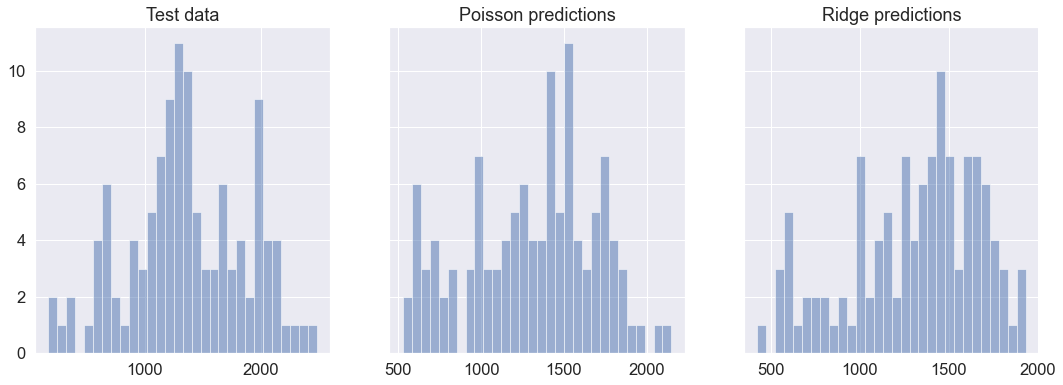

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.hist(y_test, bins=30, alpha=0.5)
ax1.set_title("Test data")
ax2.hist(poisson_pred, bins=30, alpha=0.5)
ax2.set_title("Poisson predictions")
ax3.hist(ridge_pred, bins=30, alpha=0.5)
ax3.set_title("Ridge predictions")

## Exercise 1

1. Train a `HistGradientBoostingRegressor` with `random_state=42` on the training set.
1. Compute the predictions on the test set and save it as `hist_pred`.
1. Compute the metrics for the predicitons on the model using `compute_metrics`.
1. Train a `HistGradientBoostingRegressor` with `loss='poisson'` and `random_state=42` on the training set.
1. Compute the predictions from this estimator and save it as `hist_poisson_pred`.
1. Compute the metrics for the predicitons on the model using `compute_metrics`.
1. **Extra:** Plot the prediction distrubutions for the two models and the original data.
    - **Hint** You may copy the code right above this cell.

In [26]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

hist = HistGradientBoostingRegressor(random_state=42)

hist.fit(X_train, y_train)

hist_pred = hist.predict(X_test)

compute_metrics(y_test, hist_pred)

{'mse': 176224.70298216515,
 'rmse': 419.7912612027139,
 'mean poisson deviance': 144.18220509615267}

In [27]:
hist_poisson = HistGradientBoostingRegressor(loss='poisson', random_state=42, verbose=0)
hist_poisson.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson', random_state=42)

In [28]:
hist_poisson_pred = hist_poisson.predict(X_test)
compute_metrics(y_test, hist_poisson_pred)

{'mse': 175741.02060272594,
 'rmse': 419.21476668018977,
 'mean poisson deviance': 144.96256019872538}

Text(0.5, 1.0, 'Hist Poisson predictions')

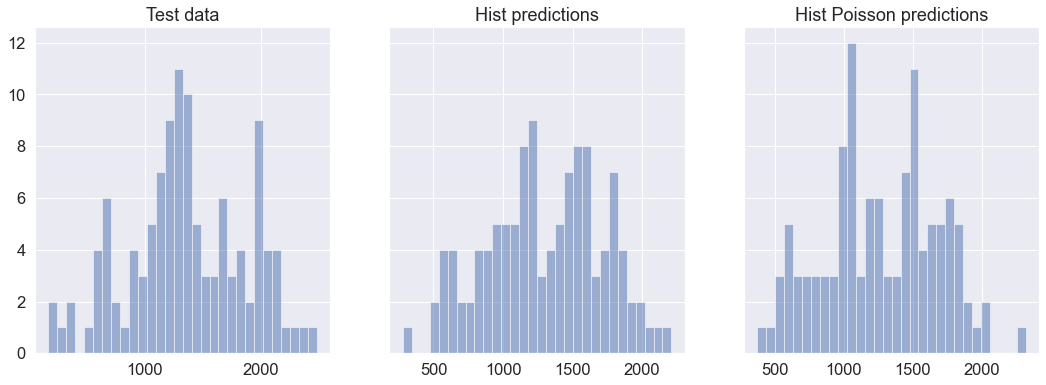

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
ax1.hist(y_test, bins=30, alpha=0.5)
ax1.set_title("Test data")
ax2.hist(hist_pred, bins=30, alpha=0.5)
ax2.set_title("Hist predictions")
ax3.hist(hist_poisson_pred, bins=30, alpha=0.5)
ax3.set_title("Hist Poisson predictions")

**If you are running locally**, you can uncomment the following cell to load the solution into the cell. On **Google Colab**, [see solution here](https://github.com/thomasjpfan//ml-workshop-advanced/blob/master/notebooks/solutions/03-ex01-solutions.py).

In [ ]:
# %load solutions/03-ex01-solutions.py

### Back to slides!

## Calibration Curve for Regressors

In [30]:
from sklearn.utils import gen_even_slices

def _calibration_curve_weighted(y_true, y_pred, n_bins=10, sample_weight=None):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    
    idx_sort = np.argsort(y_pred)
    y_pred_bin = np.zeros(n_bins)
    y_true_bin = np.zeros(n_bins)
    
    if sample_weight is not None:
        sample_weight = np.asarray(sample_weight)
    
    for i, sl in enumerate(gen_even_slices(len(y_true), n_bins)):
        if sample_weight is None:
            y_pred_bin[i] = np.average(y_pred[idx_sort][sl])
            y_true_bin[i] = np.average(y_true[idx_sort][sl])
        else:
            weights = sample_weight[idx_sort][sl]
            y_pred_bin[i] = np.average(y_pred[idx_sort][sl], weights=weights)
            y_true_bin[i] = np.average(y_true[idx_sort][sl], weights=weights)
    return y_pred_bin, y_true_bin

def plot_calibration_curve_regression(y_true, y_pred, n_bins=10, ax=None, title="", sample_weight=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    y_pred_bin, y_true_bin = _calibration_curve_weighted(y_test, y_pred, sample_weight=sample_weight)
    
    bin_centers = np.arange(1, len(y_pred_bin) + 1)
    ax.plot(bin_centers, y_pred_bin, marker='x', linestyle="--", label="predictions")
    ax.plot(bin_centers, y_true_bin, marker='o', linestyle="--", label="observations")
    ax.set(xlabel="Bin number", xticks=bin_centers, title=title)
    ax.legend()
    return ax

Train a `hist_poisson` to compare calibration curves

In [31]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_poisson = HistGradientBoostingRegressor(loss='poisson', random_state=42)
hist_poisson.fit(X_train, y_train)

hist_poisson_pred = hist_poisson.predict(X_test)

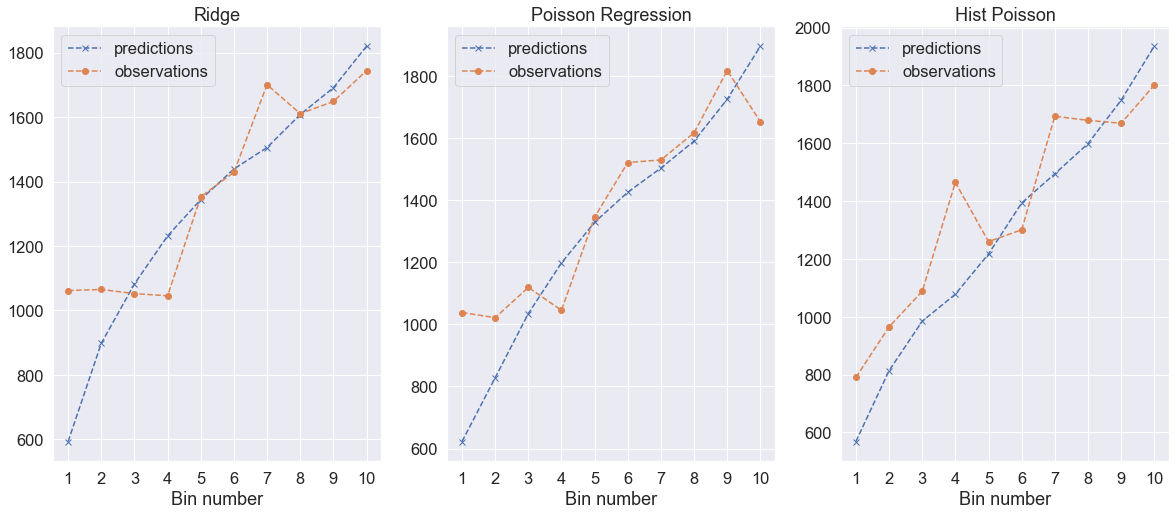

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
plot_calibration_curve_regression(y_test, ridge_pred, ax=ax1, title="Ridge")
plot_calibration_curve_regression(y_test, poisson_pred, ax=ax2, title="Poisson Regression")
plot_calibration_curve_regression(y_test, hist_poisson_pred, ax=ax3, title="Hist Poisson");

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
pr = PoissonRegressor()

In [27]:
alpha = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
fit_intercept = [True, False]
max_iter = [500, 800, 1000, 1500, 2000]
tol = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

param_grid = dict(alpha=alpha,
                  fit_intercept=fit_intercept,
                  max_iter=max_iter,
                  tol=tol)

grid = GridSearchCV(estimator=pr, param_grid=param_grid, verbose=10, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increa

Best Score:  0.388475426616933
Best Params:  {'alpha': 1, 'fit_intercept': True, 'max_iter': 500, 'tol': 1e-09}


In [37]:
alpha = [0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
fit_intercept = [True, False]
max_iter = [100, 200, 300, 400, 500]
tol = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

param_grid = dict(alpha=alpha,
                  fit_intercept=fit_intercept,
                  max_iter=max_iter,
                  tol=tol)

grid_s_poi_reg = Pipeline([
    ('prep', ct),
    ('reg', GridSearchCV(estimator=PoissonRegressor(), param_grid=param_grid, verbose=100, n_jobs=-1))
])

In [38]:
grid_s_poi_reg.fit(X_train,y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increa

[CV 2/5; 1/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-09......
[CV 2/5; 1/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-09;, score=0.474 total time=   0.0s
[CV 3/5; 2/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-08......
[CV 3/5; 2/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-08;, score=0.263 total time=   0.0s
[CV 2/5; 3/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-07......
[CV 2/5; 3/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-07;, score=0.474 total time=   0.0s
[CV 5/5; 3/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-07......
[CV 5/5; 3/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-07;, score=0.321 total time=   0.0s
[CV 4/5; 4/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-06......
[CV 4/5; 4/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-06;, score=0.283 total time=   0.0s
[CV 2/5; 5/480] START alpha=0, fit_intercept=True, max_iter=100, 

/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increa

[CV 1/5; 1/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-09......
[CV 1/5; 1/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-09;, score=0.053 total time=   0.0s
[CV 5/5; 1/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-09......
[CV 5/5; 1/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-09;, score=0.321 total time=   0.0s
[CV 4/5; 2/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-08......
[CV 4/5; 2/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-08;, score=0.283 total time=   0.0s
[CV 4/5; 3/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-07......
[CV 4/5; 3/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-07;, score=0.283 total time=   0.0s
[CV 3/5; 4/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-06......
[CV 3/5; 4/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-06;, score=0.263 total time=   0.0s
[CV 3/5; 5/480] START alpha=0, fit_intercept=True, max_iter=100, 

/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increa

[CV 3/5; 1/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-09......
[CV 3/5; 1/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-09;, score=0.263 total time=   0.0s
[CV 1/5; 2/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-08......
[CV 1/5; 2/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-08;, score=0.053 total time=   0.0s
[CV 5/5; 2/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-08......
[CV 5/5; 2/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-08;, score=0.321 total time=   0.0s
[CV 3/5; 3/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-07......
[CV 3/5; 3/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-07;, score=0.263 total time=   0.0s
[CV 2/5; 4/480] START alpha=0, fit_intercept=True, max_iter=100, tol=1e-06......
[CV 2/5; 4/480] END alpha=0, fit_intercept=True, max_iter=100, tol=1e-06;, score=0.474 total time=   0.0s
[CV 1/5; 5/480] START alpha=0, fit_intercept=True, max_iter=100, 

/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/sklearn/linear_model/_glm/glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increa

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numerical', StandardScaler(),
                                                  ['temp', 'humidity',
                                                   'wind_speed', 'rain_1h']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['federal_holiday_flag',
                                                   'school_holiday_flag',
                                                   'MONTH', 'DAY_OF_WEEK',
                                                   'DAY'])])),
                ('reg',
                 GridSearchCV(estimator=PoissonRegressor(), n_jobs=-1,
                              param_grid={'alpha': [0, 1e-06, 1e-05, 0.0001,
                                                    0.001, 0.01, 0.1, 1],
                                          'fit_intercept': [True, False],
                                          'max_iter': [100, 200, 300, 400, 500],
                                          'tol': [1e-09, 1e-08, 1e-07, 1e-06,
                                                  1e-05, 0.0001]},
                              verbose=100))])

In [39]:
print('Best Score: ', grid_s_poi_reg.steps[-1][1].best_score_)
print('Best Params: ', grid_s_poi_reg.steps[-1][1].best_params_)

Best Score:  0.28555883951872324
Best Params:  {'alpha': 1, 'fit_intercept': True, 'max_iter': 100, 'tol': 1e-09}
